In [29]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # 🔹 Compute flattened size dynamically
        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 256)  # Use dynamically computed size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def _get_flattened_size(self):
        """Passes a dummy tensor through the conv layers to compute the correct flattened size."""
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 128, 128)  # Simulate a batch with one image
            x = self.conv1(sample_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)

            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.pool(x)

            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.pool(x)

            return x.view(1, -1).size(1)  # Compute the number of features for fc1

# Instantiate the model
model = CNN()
print(model)
print(f"Computed Flattened Size: {model.flattened_size}")



CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)
Computed Flattened Size: 16384


In [30]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

# Define dataset path (modify this to your actual dataset location)
dataset_path = "birds"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to match CNN input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load dataset (PyTorch automatically labels subfolders)
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)
print(f"Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")


Classes: ['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']
Train Size: 480, Test Size: 120


In [31]:
import torch.optim as optim
import torch

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training loop
num_epochs = 10  # Adjust based on dataset size

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")
# Save model after training
torch.save(model.state_dict(), "bird_classifier.pth")
print("Model saved as bird_classifier.pth")




Epoch [1/10], Loss: 1.5713
Epoch [2/10], Loss: 0.7828
Epoch [3/10], Loss: 0.5199
Epoch [4/10], Loss: 0.4368
Epoch [5/10], Loss: 0.4110
Epoch [6/10], Loss: 0.2342
Epoch [7/10], Loss: 0.1306
Epoch [8/10], Loss: 0.0929
Epoch [9/10], Loss: 0.2111
Epoch [10/10], Loss: 0.1661
Training complete!
Model saved as bird_classifier.pth


Test Accuracy: 94.17%

Per-Class Accuracy:
AMERICAN GOLDFINCH: 91.67% (22/24)
BARN OWL: 93.75% (15/16)
CARMINE BEE-EATER: 100.00% (20/20)
DOWNY WOODPECKER: 90.48% (19/21)
EMPEROR PENGUIN: 100.00% (24/24)
FLAMINGO: 86.67% (13/15)


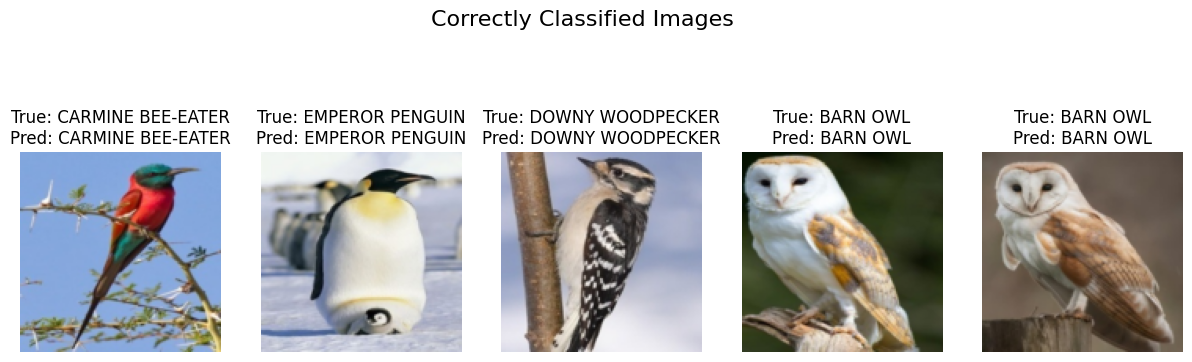

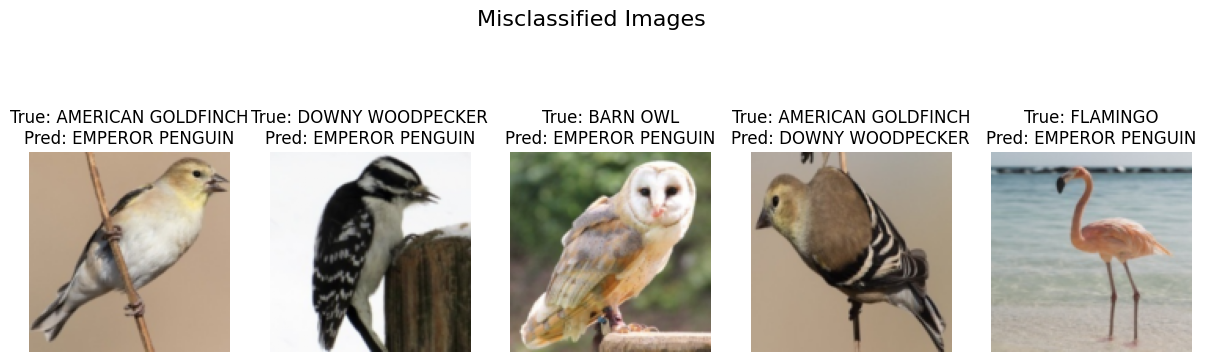

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 FIX: Remove any existing TorchCAM hooks before evaluation
for module in model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

correct = 0
total = 0
misclassified = []  # Store misclassified samples
correctly_classified = []  # Store correctly classified samples
class_correct = {i: 0 for i in range(len(test_loader.dataset.dataset.classes))}
class_total = {i: 0 for i in range(len(test_loader.dataset.dataset.classes))}

# Disable gradient computation for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Track per-class accuracy and store images
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1
                correctly_classified.append((images[i], label, predicted[i].item()))
            else:
                misclassified.append((images[i], label, predicted[i].item()))

# Compute overall accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Compute per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(test_loader.dataset.dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{class_name}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

# 🔹 Randomize selections
random.shuffle(misclassified)
random.shuffle(correctly_classified)

# 🔹 Show 5 Correctly Classified Images
num_correct = min(5, len(correctly_classified))
if num_correct > 0:
    fig, axes = plt.subplots(1, num_correct, figsize=(15, 5))
    for i in range(num_correct):
        img, true_label, predicted_label = correctly_classified[i]
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to numpy format
        img = (img * 0.5) + 0.5  # Unnormalize

        axes[i].imshow(img)
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[predicted_label]}")
        axes[i].axis("off")

    plt.suptitle("Correctly Classified Images", fontsize=16)
    plt.show()
else:
    print("No correctly classified images found.")

# 🔹 Show 5 Misclassified Images
num_misclassified = min(5, len(misclassified))
if num_misclassified > 0:
    fig, axes = plt.subplots(1, num_misclassified, figsize=(15, 5))
    for i in range(num_misclassified):
        img, true_label, predicted_label = misclassified[i]
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to numpy format
        img = (img * 0.5) + 0.5  # Unnormalize

        axes[i].imshow(img)
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[predicted_label]}")
        axes[i].axis("off")

    plt.suptitle("Misclassified Images", fontsize=16)
    plt.show()
else:
    print("No misclassified images found.")


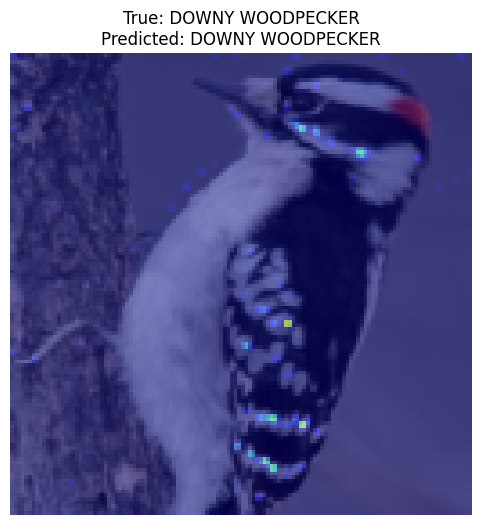

In [110]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# Ensure model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Specify the convolutional layer to extract CAMs from
cam_extractor = SmoothGradCAMpp(model, target_layer="conv2")  # Use last conv layer

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Select a random image from batch
idx = torch.randint(0, images.size(0), (1,)).item()
image = images[idx].unsqueeze(0)  # Add batch dimension
true_label = labels[idx].item()

# Enable gradient tracking
image.requires_grad = True  

# Forward pass with gradient tracking enabled
output = model(image)
_, predicted = torch.max(output, 1)
predicted_label = predicted.item()

# Compute CAM (target class is the predicted class)
activation_map = cam_extractor(predicted_label, output)

# Convert image for display
image_pil = to_pil_image((images[idx].cpu() * 0.5) + 0.5)  # Unnormalize

# Overlay CAM on image
result = overlay_mask(image_pil, to_pil_image(activation_map[0], mode="F"), alpha=0.5)

# Show the image with CAM
plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPredicted: {test_loader.dataset.dataset.classes[predicted_label]}")
plt.axis("off")
plt.show()
